![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Defect detection in aluminum castings using YOLOv5

Example using series C0001 of [GDXray](https://domingomery.ing.puc.cl/material/gdxray/). Training and validation using simulated ellipsoidal defects only. Testing on real defects only. Training, Validation and Testing images belong to the same type of wheel. The idea is to demonstrate that we can inspect a type of wheel if we train using the images of this wheel with no defects + simulated defects and test the model on X-ray images of the same type of wheel with real defects.


This example is based on YOLOv5 Tutorial from original GitHub (https://github.com/ultralytics/yolov5)


Reference:
Mery, D. (2021). [Aluminum Casting Inspection using Deep Object Detection Methods and Simulated Ellipsoidal Defects](https://link.springer.com/article/10.1007/s00138-021-01195-5). Machine Vision and Applications, 32(3), 1-16.

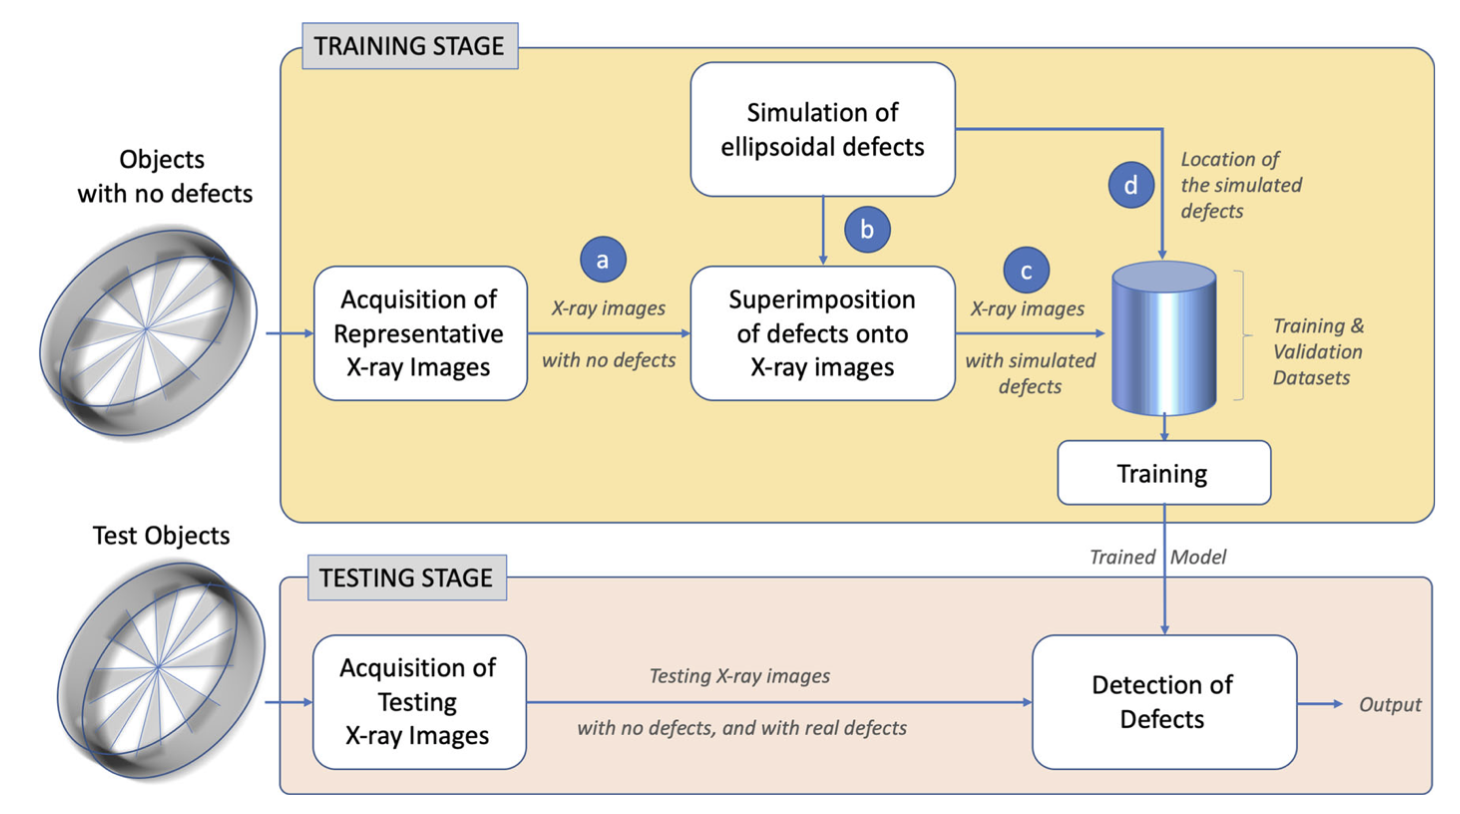

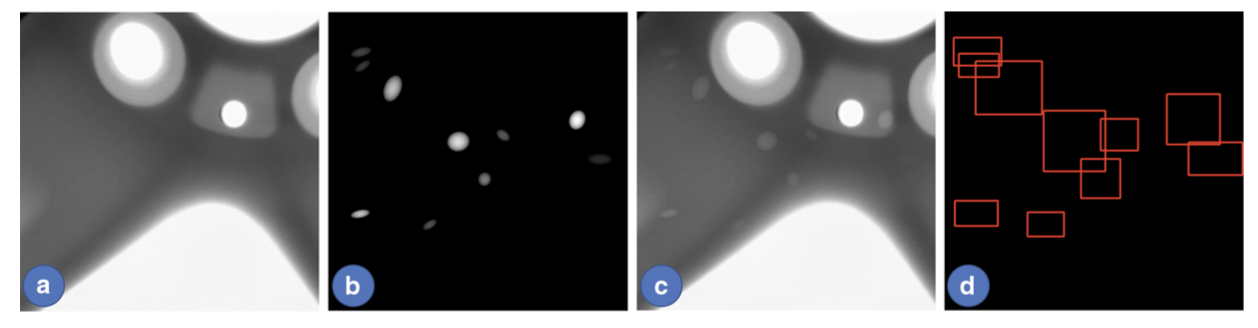

# Environment Setup
Download and install in Colab required packages and import libraries.

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15994, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15994 (delta 18), reused 18 (delta 12), pack-reused 15967
Receiving objects: 100% (15994/15994), 14.64 MiB | 20.80 MiB/s, done.
Resolving deltas: 100% (10980/10980), done.


In [ ]:
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
import os, fnmatch
import numpy as np
from IPython.display import Image, clear_output  # to display images

# Download casting data

Training, validation and testing images and annotations of series C0001 of GDXray.

In [ ]:
# Download training images and annotations
#!wget https://www.dropbox.com/s/hjfbghm53oe7uw9/cast.zip
!wget https://www.dropbox.com/s/rnqqrzz3pwzcno6/cast.zip
!unzip cast.zip


Streaming output truncated to the last 5000 lines.
  inflating: cast/labels/train/C0001_0008_02.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0008_02.txt  
  inflating: cast/labels/train/C0001_0015_53.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0015_53.txt  
  inflating: cast/labels/train/C0001_0053_06.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0053_06.txt  
  inflating: cast/labels/train/C0001_0047_73.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0047_73.txt  
  inflating: cast/labels/train/C0001_0068_90.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0068_90.txt  
  inflating: cast/labels/train/C0001_0001_26.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0001_26.txt  
  inflating: cast/labels/train/C0001_0049_76.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0049_76.txt  
  inflating: cast/labels/train/C0001_0040_52.txt  
  inflating: __MACOSX/cast/labels/train/._C0001_0040_52.txt  
  inflating: cast/labels/train/C0001_0006_07.

some training images can be removed because of RAM memory

In [ ]:
#!rm ../cast/images/train/C0001_000*
#!rm ../cast/labels/train/C0001_000*
#!rm ../cast/images/train/C0001_001*
#!rm ../cast/labels/train/C0001_001*
#!rm ../cast/images/train/C0001_002*
#!rm ../cast/labels/train/C0001_002*
#!rm ../cast/images/train/C0001_003*
#!rm ../cast/labels/train/C0001_003*
#!rm ../cast/images/val/C0001_000*
#!rm ../cast/labels/val/C0001_000*
#!rm ../cast/images/val/C0001_001*
#!rm ../cast/labels/val/C0001_001*
#!rm ../cast/images/val/C0001_002*
#!rm ../cast/labels/val/C0001_002*
#!rm ../cast/images/val/C0001_003*
#!rm ../cast/labels/val/C0001_003*



# Setup training parameters

Select model of YOLOv5, number of epochs, batchs, etc.

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
YOLO_MODEL     = 'yolov5s' # puede ser yolov5m, yolov5l, yolov5x
EPOCHS         = 50
CFG            = YOLO_MODEL+'.yaml'
TRAIN_WEIGHTS  = YOLO_MODEL+'pt'
BATCH          = 16
IMG_SIZE       = 640
YAMLFILE       = '../cast/cast.yaml'

In [ ]:
!pwd
!cat {YAMLFILE}
print('------------------')
!ls ../cast/images

/content/yolov5
# experiments on casting data from GDXray+

# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: ../cast/images/train/  
val:   ../cast/images/val/    
test:  ../cast/images/test/   

# number of classes
nc: 1

# class names
names: ['defect']
------------------
test  train  val


# Training

YOLOv5 model will be trained according setup of last cell using model {ytype}, ie if ytype is 's', then model YOLOv5s will be trained.

In [ ]:
!python train.py --img {IMG_SIZE} --batch {BATCH} --epochs {EPOCHS} --data {YAMLFILE} --cfg {CFG} --weights {TRAIN_WEIGHTS} --nosave --cache

train: weights=yolov5spt, cfg=yolov5s.yaml, data=../cast/cast.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
TEST_WEIGHTS = 'runs/train/exp/weights/last.pt' # see path in last lines of previous execution
TEST_PATH    = '../cast/images/test/'
VAL_PATH     = '../cast/images/val/'

In [ ]:
!python detect.py --weights {TEST_WEIGHTS} --img {IMG_SIZE} --conf 0.4 --source  {TEST_PATH}

detect: weights=['runs/train/exp/weights/last.pt'], source=../cast/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/720 /content/cast/images/test/C0001_0001_01.jpg: 640x640 2 defects, 11.2ms
image 2/720 /content/cast/images/test/C0001_0001_02.jpg: 640x640 2 defects, 11.3ms
image 3/720 /content/cast/images/test/C0001_0001_03.jpg: 640x640 1 defect, 11.2ms
image 4/720 /content/cast/images/test/C0001_0001_04.jpg: 640x640 1 defect, 11.3m

(640, 640, 3)


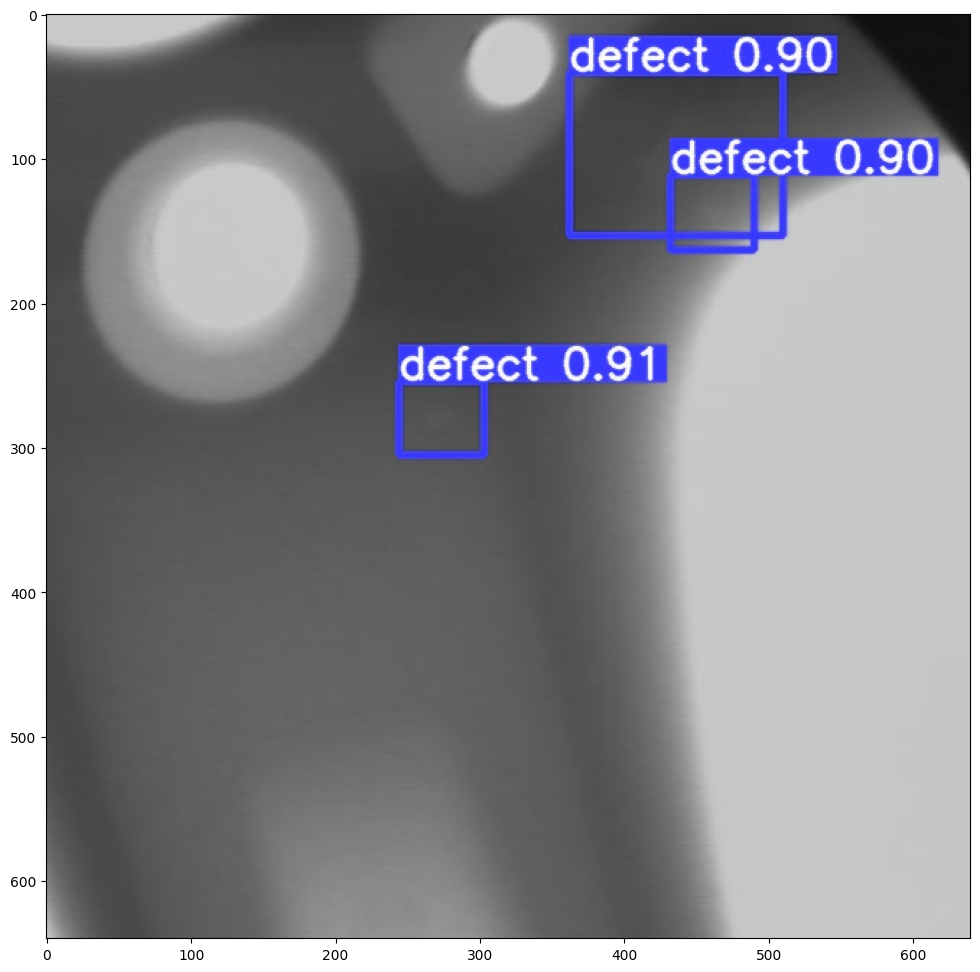

In [ ]:
I = cv2.imread('runs/detect/exp/C0001_0039_04.jpg')
print(I.shape)
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

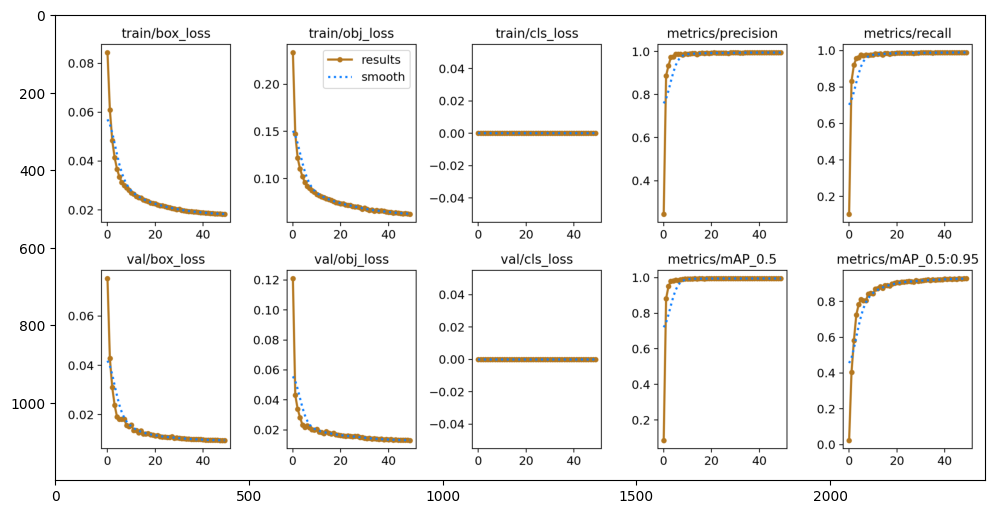

In [ ]:
I = cv2.imread('runs/train/exp/results.png')
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

# Evaluation of Performance

In [ ]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --half

val: data=../cast/cast.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.25, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/cast/labels/val.cache... 1440 images, 0 backgrounds, 0 corrupt: 100% 1440/1440 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 45/45 [00:22<00:00,  2.00it/s]
                   all       1440      14400      0.995      0.985      0.988      0.926
Speed: 0.2ms pre-process, 3.6ms inference, 1.0ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp


# Visualization

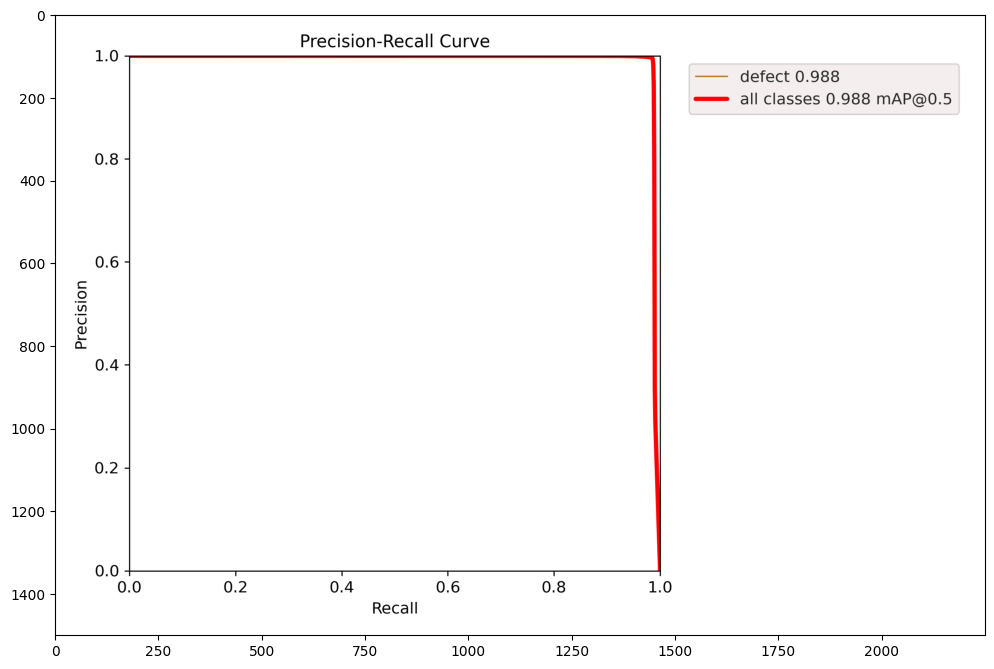

In [ ]:
I = cv2.imread('runs/val/exp/PR_curve.png')
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

In [ ]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --task test

val: data=../cast/cast.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.25, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/cast/labels/test... 419 images, 301 backgrounds, 0 corrupt: 100% 720/720 [00:00<00:00, 9545.04it/s]
test: New cache created: /content/cast/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 23/23 [00:09<00:00,  2.54it/s]
                   all        720        663      0.576      0.584      0.402      0.126
Speed: 0.3ms pre-process, 7.3ms inference, 1.0ms NMS per image 

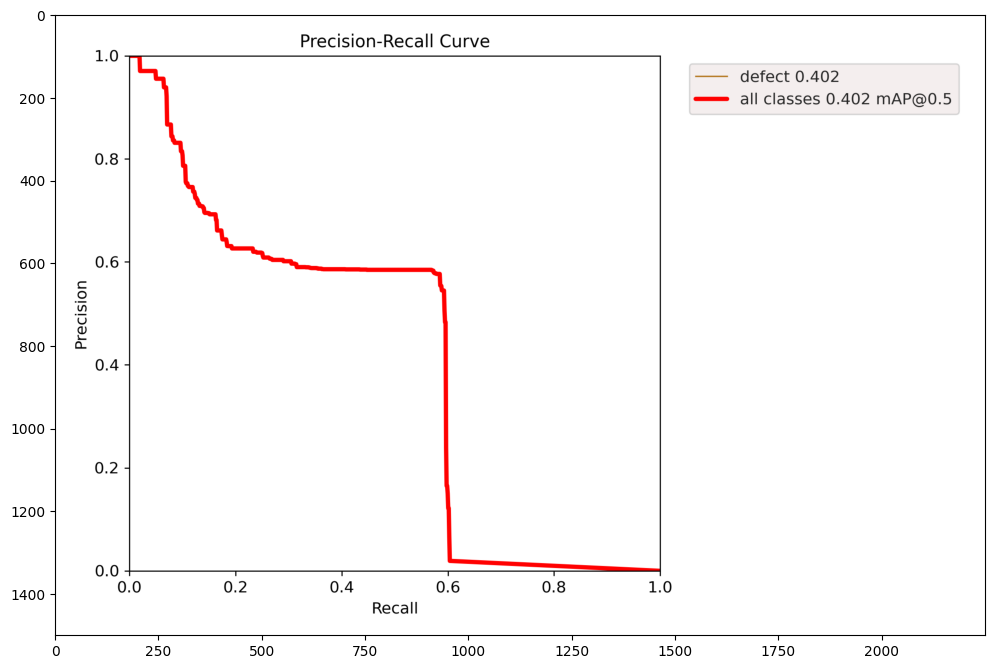

In [ ]:
I = cv2.imread('runs/val/exp2/PR_curve.png')
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

In [ ]:
def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names

def deldirfiles(dir):
    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

In [ ]:
tpath = '../cast/images/test/'
lpath = '../cast/labels/test/'
img_names = dirfiles(tpath,'*.jpg')
i = 0
print(img_names[i])


C0001_0001_01.jpg


../cast/labels/test/C0001_0001_02.txt


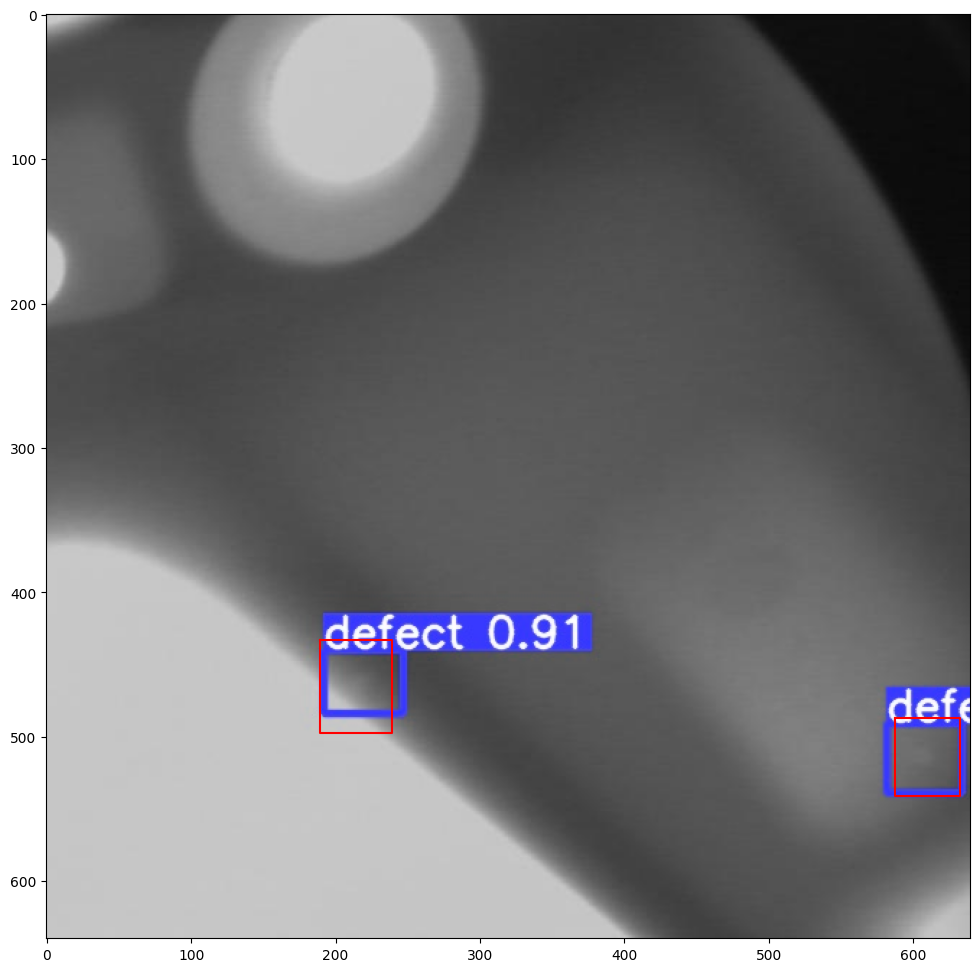

In [ ]:
i = i+1
iname = img_names[i]
I = cv2.imread('runs/detect/exp/'+iname)
N = I.shape[0]
M = I.shape[1]
plt.figure(figsize=(12,12))
plt.imshow(I)
lname = lpath+iname[:-4]+'.txt'
print(lname)
if os.path.isfile(lname):
  arr = np.loadtxt(lname)
  if len(arr.shape)==1:
    n = 1
  else:
    n = arr.shape[0]
  for k in range(n):
    if n>1:
        z = arr[k,:]
    else:
        z = arr
    x = z[1]*M
    y = z[2]*N
    w2 = z[3]*M/2
    h2 = z[4]*N/2
    x1 = x-w2
    x2 = x+w2
    y1 = y-h2
    y2 = y+h2
    plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'r')
    k = k+1

plt.show()

In [ ]:
!python detect.py --weights {TEST_WEIGHTS} --img {IMG_SIZE} --conf 0.4 --source {VAL_PATH}

detect: weights=['runs/train/exp/weights/last.pt'], source=../cast/images/val/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1440 /content/cast/images/val/C0001_0001_01.jpg: 640x640 12 defects, 11.2ms
image 2/1440 /content/cast/images/val/C0001_0001_02.jpg: 640x640 9 defects, 11.2ms
image 3/1440 /content/cast/images/val/C0001_0001_03.jpg: 640x640 10 defects, 11.2ms
image 4/1440 /content/cast/images/val/C0001_0001_04.jpg: 640x640 10 defects, 1

In [ ]:
tpath = '../cast/images/val/'
lpath = '../cast/labels/val/'


img_names = dirfiles(tpath,'*.jpg')
i = 0
print(img_names[i])


C0001_0001_01.jpg


../cast/labels/val/C0001_0001_02.txt


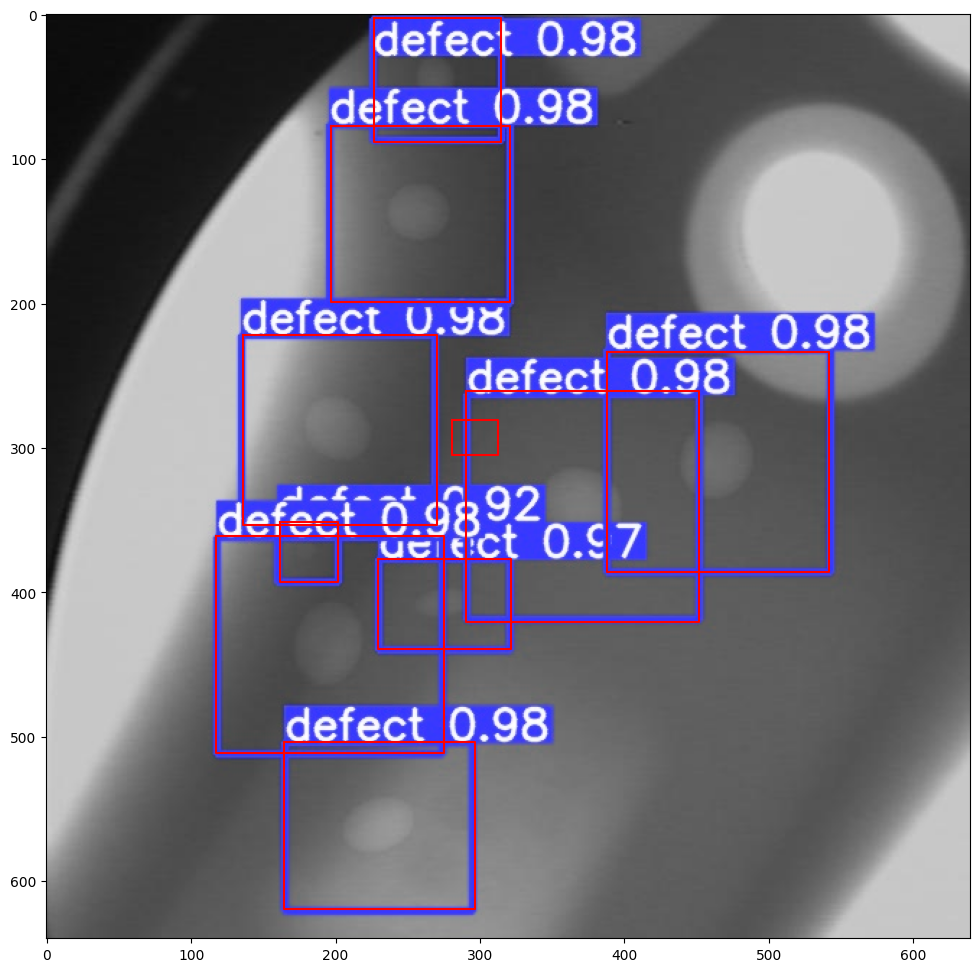

In [ ]:
i = i+1
iname = img_names[i]
I = cv2.imread('runs/detect/exp2/'+iname)
N = I.shape[0]
M = I.shape[1]
plt.figure(figsize=(12,12))
plt.imshow(I)
lname = lpath+iname[:-4]+'.txt'
print(lname)
if os.path.isfile(lname):
  arr = np.loadtxt(lname)
  if len(arr.shape)==1:
    n = 1
  else:
    n = arr.shape[0]
  for k in range(n):
    if n>1:
        z = arr[k,:]
    else:
        z = arr
    x = z[1]*M
    y = z[2]*N
    w2 = z[3]*M/2
    h2 = z[4]*N/2
    x1 = x-w2
    x2 = x+w2
    y1 = y-h2
    y2 = y+h2
    plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'r')
    k = k+1

plt.show()